<a href="https://www.kaggle.com/code/kemalmaolana/titanic-naive-bayes?scriptVersionId=122744701" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# The challenge
The competition is simple: we want you to use the Titanic passenger data (name, age, price of ticket, etc) to try to **predict who will survive and who will die**.

In this notebook, we will analyze the data and create and evaluate the model predictions

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
import sklearn.naive_bayes as nb
import sklearn.metrics as met



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Function

In [2]:
## DATA PREPARATION

# Importing data
def import_data(file_path):
    data = pd.read_csv(file_path)
    return data

# Get the first n rows of data
def get_head(data, n):
    return data.head(n)

# Display information about the dataset
def info_data(data):
    return data.info()

# Get the descriptive statistics summary of the dataset
def get_summary(data):
    return data.describe().T

# Check for missing values
def get_na(data):
    na = data.isna().any().sum()
    if na > 0:
        print(f'There are {na} features with missing values')
    else: 
        print('No missing values')
    return data.isna().sum()

# Remove a column from the dataset
def remove_column(data, column):
    data.drop(column, axis=1, inplace=True)
    return data

# Get the count of values in a column
def get_count(data, column):
    return data[column].value_counts()

# Calculate the mean of the 'Age' column by sex
def mean_sex(data, sex):
    sex = data.loc[data['Sex'] == sex, 'Age'].mean()
    return sex

# Impute missing values in the 'Age' column based on sex
def impute_age_sex(data, sex, x):
    data.loc[(data['Sex'] == sex) & (data['Age'].isnull()), 'Age'] = x
    return data

# Create bins and cut data into groups
def cut_data(data, x, label):
    return pd.cut(data, x, labels=label)

# Impute missing values in a column with the most frequent value
def impute_na(data, column, x):
    data[column].fillna(x, inplace=True)
    return data

# Change the data type of a column
def convert_type(data, column, x):
    data[column] = data[column].astype(x)
    return data

# Convert categorical variables to numerical variables
def categorize_data(data):
    # Convert Sex to numerical
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})
    # Convert Embarked to numerical
    data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    return data


## DATA VISUALIZATION

# Create a simple histogram
def simple_hist(data):
    return data.hist(bins=20)


## MODELING

# Split data into train and test sets for Gaussian Naive Bayes
def split_data(data, features, label):
    X_train, X_test, y_train, y_test = ms.train_test_split(features, label, test_size=0.25, random_state=0)
    return X_train, X_test, y_train, y_test
    
#Define Measuring The accuracy
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = met.accuracy_score(y_test, y_pred)
    precision = met.precision_score(y_test, y_pred)
    print('Accuracy =', accuracy, 'Precision =', precision)
    
#Measuring AUC by potting ROC Curve
def plot_roc_curve(model, X_test, y_test):
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fp, tp, _ = met.roc_curve(y_test, y_pred_proba) 
    auc = met.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fp, tp, label="data 1, auc="+str(auc))
    plt.legend(loc=4)
    plt.show()

    

    

# Import data

In [3]:
df_train = import_data('/kaggle/input/titanic/train.csv')

In [4]:
df_test = import_data('/kaggle/input/titanic/test.csv')

# Get Quick Summary

In [5]:
train_head = get_head(df_train, 10)
train_head

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
info_data(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
summary = get_summary(df_train)
summary

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


# Treatment with missing values

In [8]:
get_na(df_train)

There are 3 features with missing values


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

It can be seen that in the "cabin" column there are **687 examples missing**, which means that almost **80%** of the passengers did not have their cabins recorded on the Titanic.We can assume that this cabin information will not be very useful for the prediction process and we can **drop these** features from the dataset. The information "name", "PassengerID, and "ticket" cannot be used as a basis for whether the passenger will survive the accident or not, so we will discard these three feature columns.

In [9]:
df_train = remove_column(df_train, ['Cabin', 'PassengerId', 'Name', 'Ticket'])

in the embarked column we will input the value with the value that has the highest value.

In [10]:
get_count(df_train, 'Embarked')

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [11]:
df_train = impute_na(df_train, 'Embarked', 'S')

Age feature also has enough a lot of missing values. then we will impute it using mean.

In [12]:
mean_male = mean_sex(df_train,'male')
mean_female = mean_sex(df_train, 'female')
print(f'mean_male:', mean_male)
print(f'mean_female:', mean_female)

mean_male: 30.72664459161148
mean_female: 27.915708812260537


In [13]:
male_age = impute_age_sex(df_train, 'male', mean_male)
female_age = impute_age_sex(df_train, 'female', mean_female)

In [14]:
get_na(df_train)

No missing values


Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [15]:
get_head(df_train, 5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


Convert 'Fare to integer'

In [16]:
df_train = convert_type(df_train, 'Fare', int)

Make sure All features are stored in numeric form

In [17]:
df_train = categorize_data(df_train)
df_train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.000000,1,0,7,0
1,1,1,1,38.000000,1,0,71,1
2,1,3,1,26.000000,0,0,7,0
3,1,1,1,35.000000,1,0,53,0
4,0,3,0,35.000000,0,0,8,0
...,...,...,...,...,...,...,...,...
886,0,2,0,27.000000,0,0,13,0
887,1,1,1,19.000000,0,0,30,0
888,0,3,1,27.915709,1,2,23,0
889,1,1,0,26.000000,0,0,30,1


# Understand data & Prepare to create model

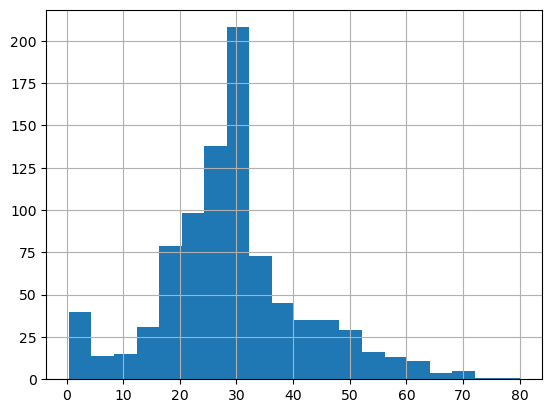

In [18]:
age_vis = simple_hist(df_train['Age'])

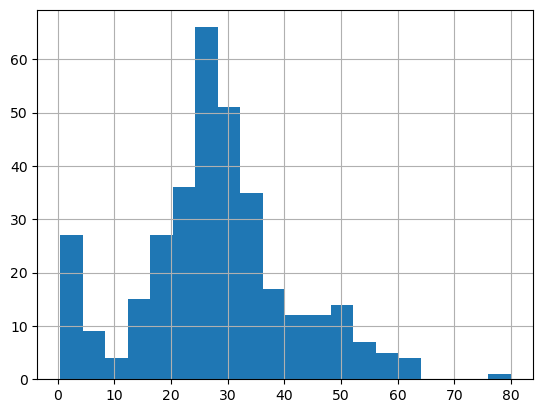

In [19]:
age_survive_vis = simple_hist(df_train['Age'].loc[df_train['Survived']==1])

**Insight:**
Based on the graph above it can be seen that only a few passengers aged between 5 and 15 years survived, as well as those over 55 years of age. Safety rates jump in the 25-35 year age range.

create new features based on Ages group


In [20]:
ages = [0,5,15,25,30,35,45,50,200]
ages_label = ['0-5', '5-15', '15-25', '25-30', '30-35', '35-45', '45-50', '>50']
age_group = cut_data(df_train['Age'], ages, ages_label)
df_train['Age Group'] = age_group
df_train['Age Group Code'] = df_train['Age Group'].cat.codes
get_count(df_train, 'Age Group')

15-25    218
30-35    212
25-30    161
35-45    114
>50       64
0-5       44
5-15      39
45-50     39
Name: Age Group, dtype: int64

Create new features based on fare group

<AxesSubplot:>

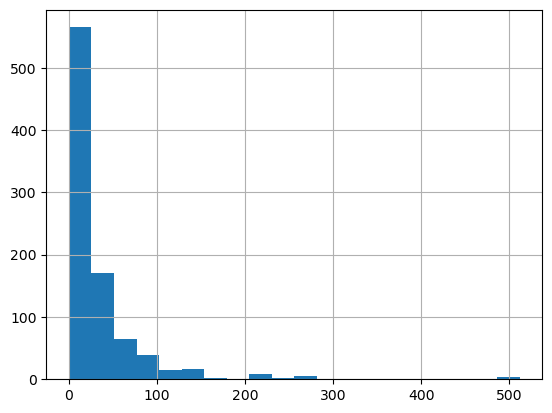

In [21]:
simple_hist(df_train['Fare'])

In [22]:
fare = [0,10,30,35,80,1000]
fare_label = ['0-10', '10-30', '30-35', '35-80', '>80']
fare_group = cut_data(df_train['Fare'], fare, fare_label)
df_train['Fare Group'] = fare_group
df_train['Fare Group Code'] = df_train['Fare Group'].cat.codes
get_count(df_train, 'Fare Group')


0-10     349
10-30    302
35-80    120
>80       74
30-35     31
Name: Fare Group, dtype: int64

to make it more concise, we combine the SibSp and Parch columns to determine the number of passengers in one group.

here:

In [23]:
number_of_people = df_train['SibSp'].astype(int) + df_train['Parch'].astype(int) + 1

In [24]:
df_train['number of people'] = number_of_people.astype(int)

In [25]:
get_head(df_train, 10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age Group,Age Group Code,Fare Group,Fare Group Code,number of people
0,0,3,0,22.000000,1,0,7,0,15-25,2,0-10,0,2
1,1,1,1,38.000000,1,0,71,1,35-45,5,35-80,3,2
2,1,3,1,26.000000,0,0,7,0,25-30,3,0-10,0,1
3,1,1,1,35.000000,1,0,53,0,30-35,4,35-80,3,2
4,0,3,0,35.000000,0,0,8,0,30-35,4,0-10,0,1
5,0,3,0,30.726645,0,0,8,2,30-35,4,0-10,0,1
6,0,1,0,54.000000,0,0,51,0,>50,7,35-80,3,1
7,0,3,0,2.000000,3,1,21,0,0-5,0,10-30,1,5
8,1,3,1,27.000000,0,2,11,0,25-30,3,10-30,1,3
9,1,2,1,14.000000,1,0,30,1,5-15,1,10-30,1,2


In [26]:
info_data(df_train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Survived          891 non-null    int64   
 1   Pclass            891 non-null    int64   
 2   Sex               891 non-null    int64   
 3   Age               891 non-null    float64 
 4   SibSp             891 non-null    int64   
 5   Parch             891 non-null    int64   
 6   Fare              891 non-null    int64   
 7   Embarked          891 non-null    int64   
 8   Age Group         891 non-null    category
 9   Age Group Code    891 non-null    int8    
 10  Fare Group        876 non-null    category
 11  Fare Group Code   891 non-null    int8    
 12  number of people  891 non-null    int64   
dtypes: category(2), float64(1), int64(8), int8(2)
memory usage: 66.8 KB


# Start To Create Model

**Selecting model**

for features that involve many continuous features, we will use the Gaussian NB model

In [27]:
X_train, X_test, y_train, y_test = split_data(df_train, df_train[['Pclass', 'Sex', 'number of people', 'Fare Group Code', 'Embarked', 'Age Group Code']], df_train['Survived'])


In [28]:
gnb = nb.GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

# Evaluating The model

Accuracy measure

In [29]:
evaluate_model(gnb, X_test, y_test)

Accuracy = 0.8071748878923767 Precision = 0.7252747252747253


Measuring AUC using ROC Curv

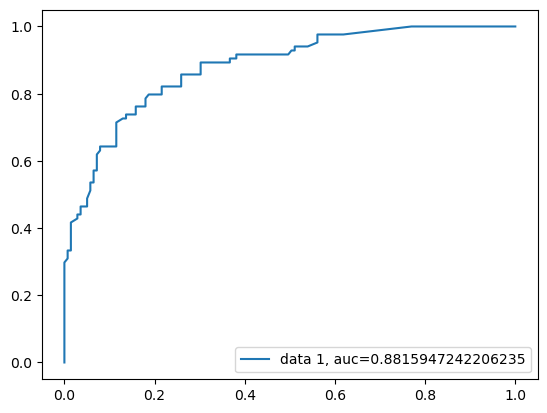

In [30]:
plot_roc_curve(gnb, X_test, y_test)


# Overview

**Based on model's performance result:**

Accuracy: 80% means that the model has correctly predicted 80% of the total cases, which is good. However, accuracy alone can be misleading, especially when there is class imbalance. Therefore, it's recommended to look at other metrics as well.

Precision: 72% means that out of the positive predictions made by the model, 72% of them are actually true positives. This metric is important when the cost of false positives is high. In other words, it measures the exactness or quality of positive predictions.

AUC: 88% means that the model is good at distinguishing between positive and negative cases. AUC measures the area under the Receiver Operating Characteristic (ROC) curve, which is a plot of true positive rate (TPR) against false positive rate (FPR) at different classification thresholds. The higher the AUC, the better the model is at making accurate predictions.